# Praktični primer 1 - Vektorsko iskanje

V tej enoti se boste seznanili z uporabo ogrodja NVIDIA RAPIDS za reševanje realnih problemov. V tem praktičnem primeru boste najprej naložili velepodatkovno zbirko s tviti povezanimi s COVID-19. Nato boste podatkovno zbirko obdelali in s pomočjo vektorizacije TF-IDF ustvarili iskalni indeks, ki ga boste uporabili za vektorsko iskanje. Zatem boste tvite še gručili z algoritmom KMeans in s kombinacijo iskalnega indeksa preverili ali tviti istih gruč govorijo o isti tematiki. Na koncu boste gruče besedil vizualizirali pri tem pa boste uporabili algoritem t-SNE. Skozi cel proces implementacije boste uporabljali knjižnice ogrodja NVIDIA RAPIDS (cuDF in cuML).

**Preden začnemo, izvedite spodnjo celico, ki vam namesti ogrodje NVIDIA RAPIDS v okolje Google Colab.**

In [1]:
!rm -rf scripts
!rm -rf rapids-csp-utils
!mkdir scripts

install_script = """
#/bin/bash

echo "Installing NVIDIA RAPIDS to Google Colab ..."

# Check GPU
echo "Checking GPU ..."
nvidia-smi

# Clone Git repository
echo 'Cloning NVIDIA RAPIDS Git repository (https://github.com/rapidsai/rapidsai-csp-utils.git)...'
rm -rf rapidsai-csp-utils
git clone https://github.com/rapidsai/rapidsai-csp-utils.git

# Install using pip
echo 'Installing NVIDIA RAPIDS using pip ...'
python /content/rapidsai-csp-utils/colab/pip-install.py

# Post-install check
echo "Checking NVIDIA RAPIDS installation ..."
python /content/scripts/post-install-check.py
"""

post_install_script = """
import cudf
import cuml
import cugraph
import cuspatial
import cuxfilter

print(f\'cuDF: {cudf.__version__}\\ncuML: {cuml.__version__}\\ncuGraph: {cugraph.__version__}\\ncuSpatial: {cuspatial.__version__}\\ncuxfilter: {cuxfilter.__version__}\')
"""

!echo "{install_script}" >> ./scripts/install-rapids-colab.sh
!echo "{post_install_script}" >> ./scripts/post-install-check.py

!bash scripts/install-rapids-colab.sh

Installing NVIDIA RAPIDS to Google Colab ...
Checking GPU ...
Wed Jul 10 09:50:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----

## Prenos in nalaganje podatkovne zbirke

Najprej prenesite podatkovno zbirko [Coronavirus (COVID-19) Tweets - early April](https://www.kaggle.com/datasets/smid80/coronavirus-covid19-tweets-early-april), ki vsebuje 8 milijonov tvitov na temo COVID-19. Podatkovna zbirka je v obliki več datotek CSV, ki jih bomo naložili v eno podatkovno strukturo cuDF DataFrame.

In [ ]:
# prenos podatkovne zbirke
!wget https://univerzamb-my.sharepoint.com/:u:/g/personal/mladen_borovic_um_si/EaxdltTKydJFv2JuimxZhuoBkS-EE0gH0hqfYiajD4Pbpg?download=1 -O coronavirus-tweets.zip

# razširitev datotek
!mkdir tweets
!unzip coronavirus-tweets.zip -d tweets/

--2024-07-10 11:59:07--  https://univerzamb-my.sharepoint.com/:u:/g/personal/mladen_borovic_um_si/EaxdltTKydJFv2JuimxZhuoBqlUYS_Kk0ivHCzODHeszHw?download=1
Resolving univerzamb-my.sharepoint.com (univerzamb-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to univerzamb-my.sharepoint.com (univerzamb-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/mladen_borovic_um_si/Documents/Share/coronavirus-tweets.zip?ga=1 [following]
--2024-07-10 11:59:07--  https://univerzamb-my.sharepoint.com/personal/mladen_borovic_um_si/Documents/Share/coronavirus-tweets.zip?ga=1
Reusing existing connection to univerzamb-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1400577995 (1.3G) [application/x-zip-compressed]
Saving to: ‘coronavirus-tweets.zip’

coronavirus-tweets. 100%[===================>]   1.30G  25.5MB/s    in 74s     

2024-07-10 12:00:21 (18.2 MB/s) - ‘coronav

In [1]:
# nalaganje podatkovne zbirke

import os
import cudf

### Tukaj vključujemo knjižnico Pandas samo zato, da lahko nastavimo lastnost display.max_colwidth v Jupyter zvezku
### Tako bo prikazan celoten tekst v stolpcu "text" v DataFrame-u
import pandas as pd
pd.set_option('display.max_colwidth', None)

# pomožna funkcija za pripravo podatkovne zbirke v obliki podatkovne strukture cuDF DataFrame
def create_df(path):
    df = cudf.DataFrame()
    chunk_number = 1

    # vsako datoteko CSV dodamo v cuDF DataFrame
    for file in os.listdir(path):
        print(f'Obdelava kosa #{chunk_number} [{path}{file}]')
        chunk = cudf.read_csv(path+file)
        chunk = chunk[chunk.lang=='en'] # zanimajo nas samo tviti v angleščini
        df = cudf.concat([df, chunk]) # združevanje
        chunk_number += 1

    return df

In [2]:
df = create_df('tweets/')

Obdelava kosa #1 [tweets/2020-04-08 Coronavirus Tweets.CSV]
Obdelava kosa #2 [tweets/2020-03-31 Coronavirus Tweets.CSV]
Obdelava kosa #3 [tweets/2020-04-11 Coronavirus Tweets.CSV]
Obdelava kosa #4 [tweets/2020-04-03 Coronavirus Tweets.CSV]
Obdelava kosa #5 [tweets/2020-04-06 Coronavirus Tweets.CSV]
Obdelava kosa #6 [tweets/2020-04-04 Coronavirus Tweets.CSV]
Obdelava kosa #7 [tweets/2020-04-12 Coronavirus Tweets.CSV]
Obdelava kosa #8 [tweets/2020-04-15 Coronavirus Tweets.CSV]
Obdelava kosa #9 [tweets/2020-04-02 Coronavirus Tweets.CSV]
Obdelava kosa #10 [tweets/2020-03-29 Coronavirus Tweets.CSV]
Obdelava kosa #11 [tweets/2020-04-07 Coronavirus Tweets.CSV]
Obdelava kosa #12 [tweets/2020-04-13 Coronavirus Tweets.CSV]
Obdelava kosa #13 [tweets/2020-04-10 Coronavirus Tweets.CSV]
Obdelava kosa #14 [tweets/2020-03-30 Coronavirus Tweets.CSV]
Obdelava kosa #15 [tweets/2020-04-05 Coronavirus Tweets.CSV]
Obdelava kosa #16 [tweets/2020-04-01 Coronavirus Tweets.CSV]
Obdelava kosa #17 [tweets/2020-04

In [3]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 4827372 entries, 2 to 473225
Data columns (total 22 columns):
 #   Column                Dtype
---  ------                -----
 0   status_id             int64
 1   user_id               int64
 2   created_at            object
 3   screen_name           object
 4   text                  object
 5   source                object
 6   reply_to_status_id    int64
 7   reply_to_user_id      int64
 8   reply_to_screen_name  object
 9   is_quote              bool
 10  is_retweet            bool
 11  favourites_count      int64
 12  retweet_count         int64
 13  country_code          object
 14  place_full_name       object
 15  place_type            object
 16  followers_count       int64
 17  friends_count         int64
 18  account_lang          int8
 19  account_created_at    object
 20  verified              bool
 21  lang                  object
dtypes: bool(3), int64(8), int8(1), object(10)
memory usage: 1.8+ GB


S funkcijo ``.info()`` preverimo strukturo podatkovne zbirke po nalaganju. Vidimo, da imamo 4,8 milijona tvitov z različnimi ostalimi atributi. Nas bo za vektorsko iskanje zanimal predvsem stolpec ``text``.

## Iskalni indeks ([TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))

Z množico besedil tvitov v podatkovni zbirki lahko zdaj ustvarimo iskalni indeks. To bomo storili s pomočjo uteži TF (ang. term frequency) in IDF (ang. inverse document frequency), ki sta zelo razširjeni v implementacijah modernih iskalnikov. Pri tem bomo uporabili knjižnico cuML in implementacijo ``TfidfVectorizer``. S tem bomo obdelavo besedila prestavili na GPE in izkoristili možnosti pospeševanja. Informativno bomo merili čas izdelave iskalnega indeksa in izpisali njegove dimenzije.

Pri ustvarjanju iskalnega indeksa imamo nekaj možnih odločitev, ki jih lahko naredimo v postopku predobdelave besedila. Te lahko bistveno vplivajo na velikost iskalnega indeksa in posledično zmožnosti shranjevanja le-tega v pomnilnik. V našem primeru se bomo najprej odločili izključiti pogoste angleške besede (ang. stop words). Med te spadajo krajše pogoste besede (npr. *the*, *at* in *are*) in vezniki. Nadalje bomo želeli ohraniti le tiste besede, ki se pojavijo v vsaj 100 tvitih (parameter ``min_df``). Morda najpomembnejša odločitev je fiksna nastavitev največjega števila značilk (v našem primeru besed). S parametrom ``max_features`` bomo to nastavili na 30.000. Z drugimi besedami, vsak tvit bomo v vektorskem prostoru predstavili z vektorjem velikosti 30.000. Če tega ne bi nastavili, bi uporabili vse besede in prišli do ogromnih dimenzij (npr. nekaj milijonov). To je lahko problematično predvsem pri uporabi indeksa. Dodatno toliko dimenzij niti ni potrebnih, saj npr. krajše pogoste besede kot je *the* ne doprinesejo veliko h kontekstu in pomenu besede za potrebe iskanja.

In [4]:
from cuml.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=100, max_features=30_000) # predobdelava besedil

%time tfidf_index = vectorizer.fit_transform(df['text']) # ustvarjanje iskalnega indeksa; s %time merimo čas izvajanja
tfidf_index.shape # izpišemo dimezije indeksa

CPU times: user 2.71 s, sys: 77.2 ms, total: 2.78 s
Wall time: 3.21 s


(4827372, 30000)

Ustvarjanje iskalnega indeksa je trajalo 3,21s. Iskalni indeks ima 4,8 milijone vrstic (tvitov) in 30.000 stolpcev (besede).

## Implementacija iskanja

S pripravljenim iskalnim indeksom lahko implementiramo iskanje. Na vhodu bomo podali iskalni niz nato pa z iskanjem po iskalnem indeksu poiskali najbolj podobne tvite. Vhodni iskalni niz moramo pri tem pretvoriti v vektorsko obliko, nato pa z mero podobnosti primerjati ta vektor z vsemi ostalimi vektorji (ti predstavljajo posamezne tvite) v iskalnem indeksu. Mera podobnosti v vektorskem prostoru je pravzaprav razdalja med dvema vektorjema. Najmanjša razdalja med vektorjema pomeni največjo podobnost med iskalnim nizom in tvitom. Za mero podobnosti se zelo pogosto uporabi kosinusna razdalja (ang. cosine distance), kjer razdalja pomeni kot med dvema vektorjema. Manjši je kot, večja je podobnost in obratno.

Pri izračunu kosinusne razdalje se lahko poslužimo preprostega matematičnega trika s katerim operacijo računanja reduciramo na skalarni produkt. Vektor vhodnega iskalnega niza in vektorje iskalnega indeksa normaliziramo z normo L2 (Evklidsko normo), rezultat pa nato izračunamo kot skalarni produkt matrike iskalnega indeksa in vhodnega iskalnega niza. Zelo priročno je, da imamo iskalni indeks že v obliki redke matrike, hkrati pa lahko za vse opisane operacije uporabimo vgrajene funkcije knjižnice cuML za delo z redkimi matrikami.

In [5]:
from cuml.common.sparsefuncs import csr_row_normalize_l2 # vključevanje funkcije za normalizacijo vrstic v redkih matrikah

# pomožna funkcija za izračun kosinusne razdalje
def similarity(query, tfidf_index, index_normalized=False):
    query = csr_row_normalize_l2(query, inplace=False) # normalizacija vhodnega niza
    if not index_normalized:
        tfidf_index = csr_row_normalize_l2(tfidf_index, inplace=False) # normalizacija iskalnega indeksa

    return tfidf_index.dot(query.T) # skalarni produkt

# pomožna funkcija za iskanje
def search(texts, query, vectorizer, tfidf_index, top_k=10):
    query_vector = vectorizer.transform(cudf.Series([query])) # pretvorba vhodnega niza v vektor
    similarities = similarity(query_vector, tfidf_index, index_normalized=True) # izračun kosinusne razdalje
    similarities = similarities.todense().reshape(-1) # pretvorba iz redke matrike v gosto
    top_k_result_idx = similarities.argsort()[-top_k:][::-1] # indeksi k najbolj podobnih tvitov

    # rezultat iskanja
    search_result = cudf.DataFrame({
        'text': texts['text'].iloc[top_k_result_idx], # izpis besedila
        'similarity': similarities[top_k_result_idx]  # izpis kosinusne razdalje
    })

    return search_result

Zdaj imamo vse potrebno za izvedbo iskanja. Preverimo implementacijo iskanja z nekaj različnimi vhodnimi nizi in merimo čas izvedbe iskanja. Pri tem upoštevajte, da iskanje izvajamo nad 4,8 milijoni tvitov.

In [6]:
%time search(df, 'computer science and NLP', vectorizer, tfidf_index)

CPU times: user 314 ms, sys: 16.7 ms, total: 330 ms
Wall time: 364 ms


,text,similarity
207793,"Computer Science has been diverging as CS + cross platform domain knowledge. #covid19 is only going to accelerate that. We will have traditional computer science as well as computer science + domain emphasis. Could be bioinformatics, drug, speech (NLP) and even agriculture.",0.616797
334632,COVID-19: what can we do with NLP? https://t.co/N31tW5glKY #NLProc #NLP #ArtificialIntelligence #COVID19 #MachineLearning https://t.co/8tsnyluruC,0.602793
237113,Will the Coronavirus bring computer and medical science together? via @InfosecurityMag\n#COVID19\n\nhttps://t.co/WIZ8AvEpq5,0.537445
270521,The latest The Phenix NLP Daily News! https://t.co/19e6mE5WzJ Thanks to @cesarbus99 @NursingTimes @KingLionheart #covid19 #coronavirus,0.513698
319798,The latest The Phenix NLP Daily News! https://t.co/19e6mE5WzJ Thanks to @sarathburri @sophiapandeya @TokyoTherapy #coronavirus #covid19,0.513698
227401,The latest The Phenix NLP Daily News! https://t.co/19e6mEnxrh Thanks to @LuciaGannon @MGHNeurosurg @NitinKumar7728 #coronavirus #covid19,0.513698
132223,The latest The Phenix NLP Daily News! https://t.co/19e6mE5WzJ Thanks to @mochi_tannies7 @tediscript @LaneRole #covid19 #coronavirus,0.513698
272106,The latest The Phenix NLP Daily News! https://t.co/19e6mEnxrh Thanks to @SPA_WELI @ZSpezakis @efdlan #covid19 #coronavirus,0.513698
280881,The latest The Phenix NLP Daily News! https://t.co/19e6mE5WzJ Thanks to @JMGayton1 @mi6rogue @DrKateLovett #coronavirus #covid19,0.513698
306163,The latest The Phenix NLP Daily News! https://t.co/19e6mE5WzJ Thanks to @nishantranaCRM @SeanYoo @BethanyDietz #covid19 #coronavirus,0.513698


In [7]:
%time search(df, 'flu symptoms', vectorizer, tfidf_index)

CPU times: user 104 ms, sys: 808 µs, total: 105 ms
Wall time: 122 ms


,text,similarity
188959,Flu like Symptoms\nW T F ?\n\n🦠😊\n#googlesearch #POIS #coronavirus #flu https://t.co/n3kGqegE1E,0.900296
444376,@KFILE #COVID19 is not the flu.,0.716574
307743,@Goddess1345 #COVID19 is not flu.,0.716574
343750,"If #COVID19 symptoms were no different from the symptoms of Common flu, then are the people dying from #coronavirus or the common flu?",0.714132
403546,Now do the flu. #Coronavirus,0.710668
373749,Still less than the flu #Coronavirus,0.710668
474911,Treating flu and Covid symptoms. Please listen to and share. \nhttps://t.co/LBillt4XPg\n\n#COVID19 \n#COVIDー19 \n#Flu,0.704565
18122,NOT the Flu 😷 #COVID19 https://t.co/DcxPhJQuf9,0.701335
291576,How #COVID19 is NOT lle the flu... https://t.co/VvNMyQBvNl,0.701335
556136,How #Covid19 is NOT the flu.\nhttps://t.co/qTUfQneAJI,0.701335


In [8]:
%time search(df, 'lockdown rules', vectorizer, tfidf_index)

CPU times: user 207 ms, sys: 4.18 ms, total: 211 ms
Wall time: 224 ms


,text,similarity
101786,Why #coronavirus #lockdown rules are not obeyed by everyone ... @vrtnws @VTMNIEUWS #begov https://t.co/rmJDut8JIS,0.961322
310542,Motoring rules during the coronavirus lockdown \n\nhttps://t.co/mQjrSUeg34\n\n#coronavirus #lockdown #motoring https://t.co/Sl8IEPTWXd,0.869562
335794,Rules are rules #coronavirus https://t.co/zrWTTC9LQN,0.834315
19467,@RA2B3 No rules #coronavirus,0.817091
7848,It's the rules #COVID19 https://t.co/qF5edrjDe9,0.807312
174155,Hydration rules.\n#coronavirus \n\nhttps://t.co/NETi6yu5jj,0.801490
431061,Now it up to us to follow the rules of this lockdown\n#Covid_19 https://t.co/f1yKOWl1sT,0.761279
66901,"""We dont care who you are, rules are rules""\n#FjPM #COVID19",0.705695
468297,What are France's new lockdown rules? #COVID19 https://t.co/rsdU5bTTqh,0.701348
362205,New Rules. #coronavirus https://t.co/FTkl2PRviq,0.700141


Kot vidimo iskanje deluje hitro (čas izvajanja je pod 500ms), hkrati pa dobivamo smiselne rezultate iskanja. S tem smo uspešno implementirali vektorsko iskanje, lahko pa gremo še korak naprej. Ker imamo na voljo vektorski prostor, ki opisuje vsebino tvitov, jih lahko podrobneje analiziramo. Poskusimo se lotiti še tega in uporabimo še kakšno funkcionalnost knjižnice cuML.

## Gručenje (opcijsko)

Poskusimo najti gruče tvitov, ki so si med seboj podobni. Sklepamo lahko, da bodo posamezne gruče tvitov imele podobno tematiko in ker imamo samo tvite povezane s COVID-19 lahko s takšnim gručenjem analiziramo različne tematike tvitov povezane s to boleznijo. Algoritme gručenja smo spoznali že v prejšnjih enotah, v tej enoti pa bomo uporabili algoritem KMeans. Število gruč bomo za začetek nastavili na 10, kasneje pa lahko z uporabo naprednejših postopkov po potrebi to tudi spremenimo.

Pri gručenju bomo morali upoštevati še omejitev pomnilnika na GPE. Naš ogromen iskalni indeks je v obliki redke matrike, na žalost pa algoritem KMeans v knjižnici cuML ne podpira izvajanja algoritma nad redkimi matrikami. Če pretvorimo naš iskalni indeks iz redke matrike v gosto, ga ne bomo mogli celega shraniti v pomnilnik GPE. Zato bomo vzeli vzorec iskalnega indeksa, ki bo zajemal prvih 100.000 tvitov. Vzorec bomo pretvorili v gosto matriko nato pa izvedli algoritem KMeans na GPE. Velikost vzorca lahko spreminjamo glede na omejitve pomnilnika naše GPE, dodatno pa lahko ponovno ustvarimo iskalni indeks z manj značilkami (parameter ``max_features``).

In [35]:
sample_size = 100_000 # velikost vzorca

tweets = cudf.Series(df['text'])
sample_data = tfidf_index[:sample_size].todense() # vzorec iskalnega indeksa
sample_tweets = tweets[:sample_size].reset_index(drop=True) # besedila tvitov v vzorcu iskalnega indeksa

In [36]:
from cuml.cluster import KMeans

n_clusters = 10 # število gruč

model = KMeans(n_clusters=n_clusters, n_init=1, max_iter=1000)

%time kmeans = model.fit(sample_data) # izvedba algoritma KMeans
%time clusters = kmeans.predict(sample_data) # napoved gruč v vzorcu
%time distances = kmeans.transform(sample_data) # izračun razdalj

CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 14.5 s
CPU times: user 333 ms, sys: 0 ns, total: 333 ms
Wall time: 332 ms
CPU times: user 629 ms, sys: 0 ns, total: 629 ms
Wall time: 627 ms


Gručenje z algoritmom KMeans je trajalo 14,5s. Hkrati smo pridobili še gruče in razdalje, ki jih bomo uporabili pri analizi za vizualizacijo rezultata. Zaenkrat poglejmo kaj so nekatere značilne ključne besede za vsako gručo.

In [37]:
import numpy as np

sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # urejanje centroidov gruč
terms = vectorizer.get_feature_names()

cluster_terms = sorted_centroids[:, :100].get() #izbor 100 najpogostejših besed v vsaki gruči

# izpis ključnih besed
for i, c1 in enumerate(cluster_terms):
    cluster = set(c1)
    for j, c2 in enumerate(cluster_terms):
        if i == j:
            continue
        cluster -= set(c2)

    cluster = c1[np.isin(c1, list(cluster))][:5] # izbor prvih 5 ključnih besed
    print(f'Gruča {i}:', ' | '.join(terms[cluster].to_arrow().to_pylist()))

Gruča 0: impact | disease | lockdownextension | amid | covid19pandemic
Gruča 1: confirmed | reports | 149 | 82 | 08
Gruča 2: lifts | leave | 76 | lifted | healthy
Gruča 3: london | old | infected | year | bus
Gruča 4: life | normal | hanuman | saving | living
Gruča 5: step | g20org | poorest | ensure | needs
Gruča 6: prine | john | rip | songwriter | dies
Gruča 7: didn | miss | months | lockdownday10 | knew
Gruča 8: announces | public
Gruča 9: stayathome | flattenthecurve | washyourhands | replacesongtitlewithcircuitbreaker | circuitbreaker


Izpišimo še število tvitov po gručah:

In [38]:
for c in range(0, n_clusters):
    print(f'Gruča {c}: {len(sample_tweets[clusters == c])} tvitov')

Gruča 0: 5710 tvitov
Gruča 1: 3886 tvitov
Gruča 2: 3418 tvitov
Gruča 3: 959 tvitov
Gruča 4: 1608 tvitov
Gruča 5: 4009 tvitov
Gruča 6: 660 tvitov
Gruča 7: 1209 tvitov
Gruča 8: 76965 tvitov
Gruča 9: 1576 tvitov


Iz zgornjega izpisa vidimo veliko večino tvitov v gruči 8. Sodeč po ključnih besedah za to gručo je večina tvitov povezanih z javnim obveščanjem o stanju bolezni COVID-19. Poglejmo še ključne besede za druge gruče. Zanimive so gruče 0 (vplivi COVID-19), 6 (smrt Johna Prinea) in 9 (pozivi za umivanje rok in ostajanje doma).

Izberimo gruče 0, 6 in 9 ter poglejmo primere tvitov v teh gručah. Spodnje celice zaženite večkrat in preverite ali tviti sovpadajo z zgoraj izpisanimi ključnimi besedami.

In [39]:
# primeri tvitov v gruči 0
sample_tweets[clusters == 0].to_pandas().sample()

13946    Classroom ➡️ Virtual Training\n\n🙋🏻‍♀️🙋🏻‍♂️WHO WANTS FREE TRAINING?\n\nZoom has become THE platform to use to connect with others during COVID-19.\n\nComment below if you would like FREE training through Zoom and what topics you want to hear!👇🏼\n\n #zoom #virtualtraining #COVID19 #ledotsocial https://t.co/9VS0SnRmXh
Name: text, dtype: object

In [40]:
# primeri tvitov v gruči 6
sample_tweets[clusters == 6].to_pandas().sample()

15910    Damn you #COVID19 for taking John Prine 😔
Name: text, dtype: object

In [41]:
# primeri tvitov v gruči 9
sample_tweets[clusters == 9].to_pandas().sample()

35574    I call this masterpiece “Ask and ye shall receive... a Lightfoot in your ass if your don’t stay the fuck at home”.\n\nI have made my #twitter comeback just to bring you this treasure.\nYou’re welcome. Don’t be a fuck nut. #StayAtHome #sweethomechicago \n#washyourhands \n#COVID19 https://t.co/VX6fprtfHR
Name: text, dtype: object

Izberimo 10 naključnih tvitov iz izbranih gruč 0, 6 in 9 ter jih vizualizirajmo. Za vizualizacijo bomo uporabili algoritem [t-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a).

In [45]:
cluster0_idx = []
cluster6_idx = []
cluster9_idx = []
for i in range(0, 10):
    cluster0_idx.append(sample_tweets[clusters == 0].to_pandas().sample().index[0]) # 'impact of COVID-19' 
    cluster6_idx.append(sample_tweets[clusters == 6].to_pandas().sample().index[0]) # 'RIP John Prine'
    cluster9_idx.append(sample_tweets[clusters == 9].to_pandas().sample().index[0]) # 'stay at home/flatten the curve' 

## t-SNE

S [cuML t-SNE](https://docs.rapids.ai/api/cuml/stable/api/#tsne) bomo vizualizirali vektorski prostor tvitov tako, da ga bomo preslikali v 2D prostor (sliko). Naključnih 10 tvitov posamezne izbrane gruče bomo označili z barvnim trikotnikom in se prepričali, da so tviti tudi vizualno blizu skupaj.

In [46]:
from cuml.manifold import TSNE

# izvedba t-SNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=2024, n_iter=1000, method='fft')
tsne_kmeans = tsne_model.fit_transform(distances)

/home/mladen/.local/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


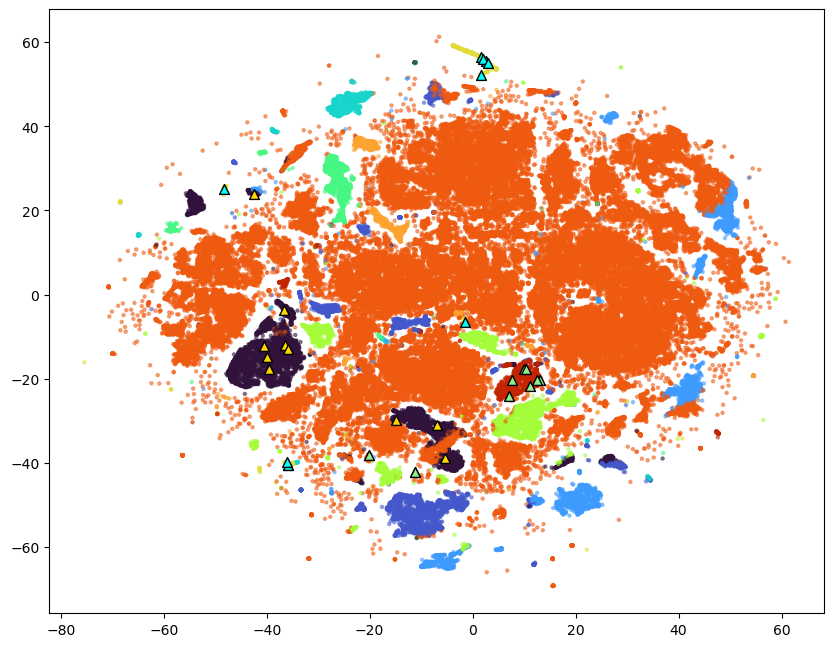

In [47]:
# vizualizacija
from bokeh.palettes import Turbo256

# priprava podatkov za vizualizacijo
step = len(Turbo256) / n_clusters
kmeans_df = cudf.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = clusters
kmeans_df['tweets'] = sample_tweets
kmeans_df['colour'] = [Turbo256[int(i * step)] for i in clusters.tolist()]
kmeans_df = kmeans_df.to_pandas()

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
ax.scatter(kmeans_df['x'], kmeans_df['y'], color=kmeans_df['colour'], s=5, alpha=0.5)

# izris vzorcev gruč 0, 6 in 9
samples_0 = kmeans_df.iloc[cluster0_idx].copy()
samples_6 = kmeans_df.iloc[cluster6_idx].copy()
samples_9 = kmeans_df.iloc[cluster9_idx].copy()

ax.scatter(samples_0['x'], samples_0['y'], color='gold', marker='^', edgecolor='black', s=50)
ax.scatter(samples_6['x'], samples_6['y'], color='cyan', marker='^', edgecolor='black', s=50)
ax.scatter(samples_9['x'], samples_9['y'], color='lightgreen', marker='^', edgecolor='black', s=50);

Iz zgornje slike lahko vidimo eno veliko gručo (gruča 8) in več manjših. Nekatere gruče so razpršene (gruči 0 in 6), nekatere pa so kompaktne (gruča 9).

V tej enoti ste implementirali vektorsko iskanje po ogromnem številu tvitov, pri tem pa ste implementirali delovni tok z uporabo ogrodja NVIDIA RAPIDS in knjižnic cuDF in cuML. Na primeru ste lahko videli prednosti takšne implementacije in pospeševanja na GPE. Hkrati ste na koncu videli možnost dodatne analize in vizualizacije, kjer ste prav tako uporabili ogrodje NVIDIA RAPIDS.